In [164]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
from tqdm import tqdm
from python_speech_features import mfcc, logfbank

In [186]:
def plot_signal(signal):
    fig, ax = plt.subplots()
    fig.suptitle('Time Series', size=16)
    ax.plot(signal)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def plot_fft(fft):
    fig, ax = plt.subplots()
    fig.suptitle('Fourier Transform', size=16)
    Y, freq = fft[0], fft[1]
    ax.plot(freq, Y)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def plot_fbank(fbank):
    fig, ax = plt.subplots()
    fig.suptitle('Filter Bank Coefficients', size=16)
    ax.imshow(fbank, cmap='hot', interpolation='nearest')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def plot_mfccs(mfccs):
    fig, ax = plt.subplots()
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    ax.imshow(mfccs, cmap='hot', interpolation='nearest')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [151]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

In [2]:
CAPUCHIN_DIR = os.path.join('archive', 'Parsed_Capuchinbird_Clips')
NOT_CAPUCHIN_DIR = os.path.join('archive', 'Parsed_Not_Capuchinbird_Clips')

In [3]:
n_pos = len(os.listdir(CAPUCHIN_DIR))
n_neg = len(os.listdir(NOT_CAPUCHIN_DIR))

In [48]:
pos_paths = [os.path.join(CAPUCHIN_DIR,f) for f in os.listdir(CAPUCHIN_DIR)]
neg_paths = [os.path.join(NOT_CAPUCHIN_DIR,f) for f in os.listdir(NOT_CAPUCHIN_DIR)]

tmp = zip\
    (
        os.listdir(CAPUCHIN_DIR), 
        pos_paths,
        np.ones(len(pos_paths))
    )

df = pd.DataFrame(data=tmp)

tmp = zip\
    (
        os.listdir(NOT_CAPUCHIN_DIR), 
        neg_paths,
        np.zeros(len(neg_paths))
    )

df = pd.concat([df, pd.DataFrame(data=tmp)], axis=0)
df.rename(columns={0:'filename', 1:'path', 2:'class'}, inplace=True)

df.set_index('filename', inplace=True)
for f in df.index:
    rate, signal = wavfile.read(df.at[f, 'path'])
    df.at[f, 'length'] = signal.shape[0] / rate

df.to_csv('sounds.csv')

df.reset_index(inplace=True)

In [49]:
classes = np.unique(df['class'])
class_dist = df.groupby(['class'])['length'].mean()

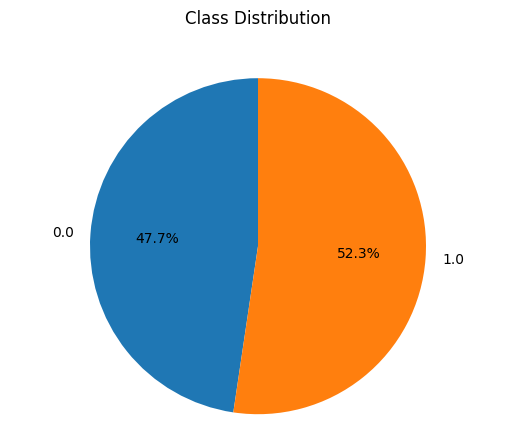

In [50]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=classes, startangle=90, autopct='%1.1f%%')
ax.axis('equal')
plt.show()

In [189]:
rdindex = np.random.choice(df[df['class'] == 1].index)

signal, rate = librosa.load(df.iloc[184].path, sr=44100)
mask = envelope(signal, rate, 0.0005)
signal = signal[mask]
bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T # nfft = 44100 / 40 = 1102.5
mfccs = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
fft = calc_fft(signal, rate)

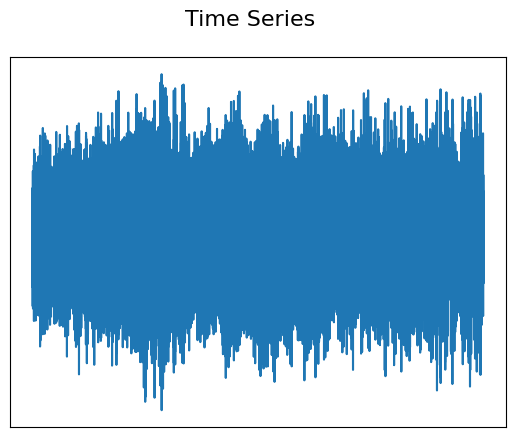

In [190]:
plot_signal(signal)
plt.show()

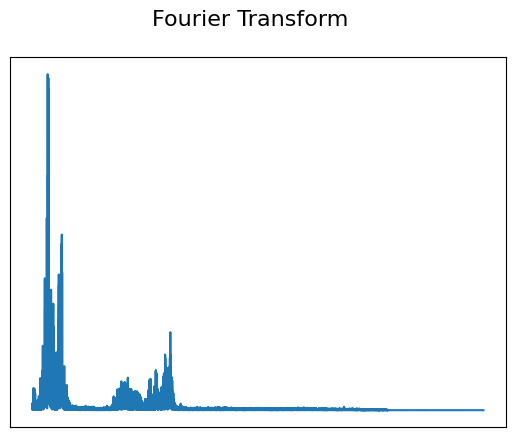

In [191]:
plot_fft(fft)
plt.show()

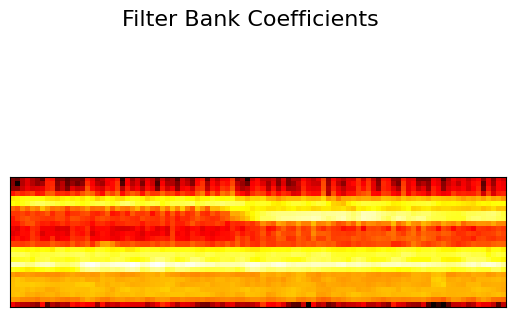

In [192]:
plot_fbank(bank)
plt.show()

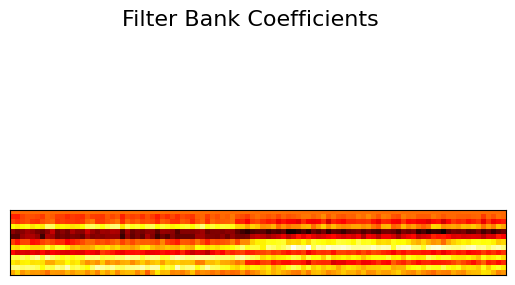

In [193]:
plot_fbank(mfccs)
plt.show()

In [195]:
if len(os.listdir('clean')) == 0:
    for i in tqdm(df.index):
        record = df.iloc[i]
        path = record.path
        signal, rate = librosa.load(path, sr=16000)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename=f'clean/{record.filename}', rate=rate, data=signal[mask])

100%|██████████| 810/810 [00:06<00:00, 122.10it/s]
